In [3]:
import gym
import gym_oscillator
import oscillator_cpp
from stable_baselines.common import set_global_seeds
from IPython.display import clear_output
from stable_baselines.common.policies import MlpPolicy, LstmPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv,SubprocVecEnv,VecNormalize, VecEnv
from stable_baselines import PPO2, DDPG, DQN, PPO1, A2C
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
import importlib

from stable_baselines.common.vec_env import VecEnv
from stable_baselines.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info

In [4]:
def draw_plots(states_x,states_y,dict_power,coupling_pwr,save=False,single=False,nosc=2000):
    """
    Helper function to draw plots
    """
    path = 'imgs/'
    path = path + str(nosc) +'/'
    plt.figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Oscillation plot with coupling strength: {}, Number of oscillators: {}'.format(coupling_pwr,nosc))
    plt.plot(np.arange(0,500),states_x[0:500])
    plt.plot(np.arange(499,1500),states_x[499:1500])
    plt.plot(np.arange(1500,2000),states_x[1500:2000])
#     plt.plot(np.arange(0,2000),[-0.27]*2000,c='red')
#     if single:
#         plt.plot([couplingkeys_pwr]*300,np.linspace(-1.5,1.5,300),c='green')
#     else:
#         plt.plot([dict_power[coupling_pwr]]*300,np.linspace(-1.5,1.5,300),c='green')
    
    plt.xlabel('Number of steps')
    plt.ylabel('Mean Field, X')
    if save:
        plt.savefig(path+'Mean_Field_X_{}{}'.format(coupling_pwr,'.png'))
        print('saved')
    else:
        plt.show()
    plt.figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Oscillation plot with coupling strength: {}, Number of oscillators: {}'.format(coupling_pwr,nosc))
    
    plt.plot(np.arange(0,500),states_y[0:500])
    plt.plot(np.arange(499,1500),states_y[499:1500])
    plt.plot(np.arange(1500,2000),states_y[1500:2000])
#     plt.plot(np.arange(0,2000),[-0.27]*2000,c='red')
#     if single:
#         plt.plot([coupling_pwr]*300,np.linspace(-1.5,1.5,300),c='green')
#     else:
#         plt.plot([dict_power[coupling_pwr]]*300,np.linspace(-1.5,1.5,300),c='green')
    plt.xlabel('Number of steps')
    plt.ylabel('Mean Field, Y')
    if save:
        plt.savefig(path+'Mean_Field_Y_{}{}'.format(coupling_pwr,'.png'))
    else:
        plt.show()
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Oscillation plot with coupling strength: {}, Number of oscillators: {}'.format(coupling_pwr,nosc))
    plt.xlabel('Mean Field, Y')
    plt.ylabel('Mean Field, X')
    plt.plot(states_y[0:500],states_x[:500])
    plt.plot(states_y[499:1500],states_x[499:1500])
    if save:
        plt.savefig(path+'Mean_Field_XY_{}{}'.format(coupling_pwr,'.png'))
    else:
        plt.show()

In [5]:
#env = gym.make('oscillator-v0')
env_id = 'oscillator-v0'
num_cpu = 16
#env = DummyVecEnv([lambda: env]) 
# The algorithms require a vectorized environment to run

In [6]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        print(env.reset().shape)
        return env
    set_global_seeds(seed)
    return _init

In [7]:
env = gym.make('oscillator-v0')

In [8]:
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)
(150,)


In [9]:
model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log="Bursting/",n_steps =1)
#model.learn(10000000)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
#model.save('bursting_baseline.tf')

In [11]:
def get_stds(x,border=0.2):
    """
    Function to get standart deviation inside border with window
    x - input data: list[]
  download  border - border to slice over: float
    return first occurence bellow border: float
    """
    window = 250
    for i in range(len(x)-window):
        std_now = np.std(x[i:i+window])
        #stds_.append(std_now)
        if std_now < 0.2:
            return i
    #return stds_
    

In [12]:
def itterate_environment(coupling_power):
    """
    Function to draw plot for coupling_power
    """
    env = gym.make('oscillator-v0',)
    env.__init__(epsilon=coupling_power)
     # The algorithms require a vectorized environment to run
    rews_ = []
    obs_ = []
    obs = env.reset()
    acs_ = []
    states_x = []
    states_y = []
    for i in range(500):
        #action, _states = model.predict(obs)

        obs, rewards, dones, info = env.step([0])
        print(obs)
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(0)
        rews_.append(rewards)
        
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(action)
        rews_.append(rewards)
        
    for i in range(500):
        obs, rewards, dones, info = env.step([0])
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(0)
        rews_.append(rewards)
    draw_plots(states_x,states_y,None,0.03,False,True)


In [13]:
def draw_gif():
    """
    Function to draw plot for coupling_power
    """
    coupling_power = 0.03
    env = gym.make('oscillator-v0',)
    env.__init__(epsilon=coupling_power)
     # The algorithms require a vectorized environment to run
    rews_ = []
    obs_ = []
    obs = env.reset()
    acs_ = []
    states_x = []
    states_y = []
    for i in range(500):
        #action, _states = model.predict(obs)

        obs, rewards, dones, info = env.step([0])
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(0)
        rews_.append(rewards)
        
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step([0])
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(action)
        rews_.append(rewards)
        
    for i in range(500):
        obs, rewards, dones, info = env.step([0])
        states_x.append(env.x_val)
        states_y.append(env.y_val)
        obs_.append(obs[0])
        acs_.append(0)
        rews_.append(rewards)
    saving_path = 'gif_folder/'
    step = 20
    for iter_x in range(int(len(states_x)/step)):
        plt.title('Oscillation plot with coupling strength {}'.format(coupling_power))
        plt.xlabel('Mean Field, Y')
        plt.ylabel('Mean Field, X')
        plt.plot(states_x[iter_x*step:(iter_x+1)*step],states_y[iter_x*step:(iter_x+1)*step])
        plt.savefig(saving_path)
    

In [14]:
env = gym.make('oscillator-v0',)
coupling_power = 0.2
#model = model.load('bursting_baseline.tf')
env.__init__(epsilon=coupling_power,nosc=1000)
 # The algorithms require a vectorized environment to run
rews_ = []
obs_ = []
obs = env.reset()
acs_ = []
states_x = []
states_y = []
y_1 = []
y_900 = []
for i in range(5000):
    #action, _states = model.predict(obs)
    
    obs, rewards, dones, info = env.step([0])
    
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)
    y_1.append(env.y_one)
    y_900.append(env.y_900)
for i in range(15000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(action)
    rews_.append(rewards)
    y_1.append(env.y_one)
    y_900.append(env.y_900)
for i in range(15000):
#action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step([0])
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)
    y_1.append(env.y_one)
    y_900.append(env.y_900)
#draw_plots(states_x,states_y,None,0.3,False,True)

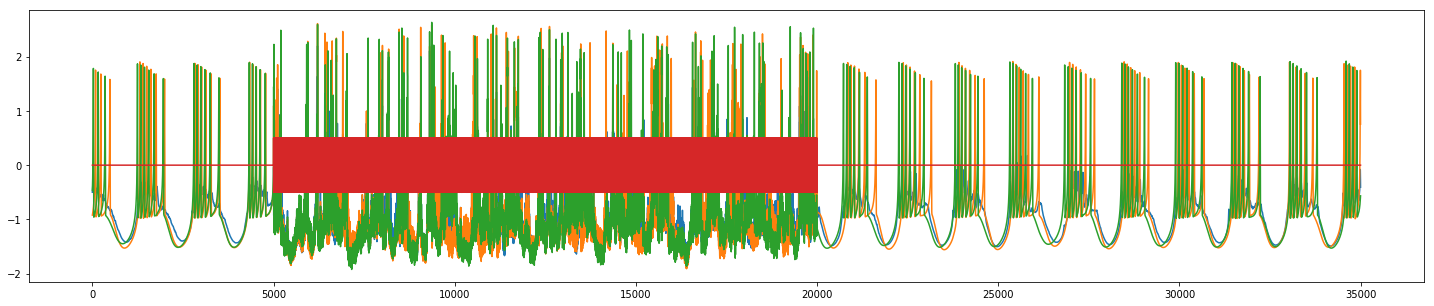

In [15]:
plt.figure(figsize=(25,5))
#plt.plot(y_one)
plt.plot(states_x)
#Potential of single neuron (#1)
plt.plot(y_1)
#Potential of single neuron (#900)
plt.plot(y_900)
plt.plot(acs_)

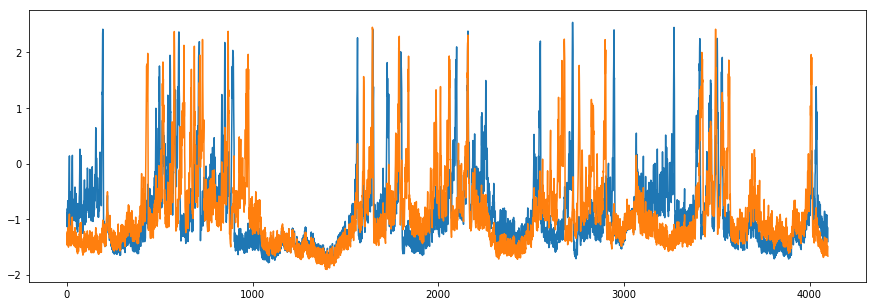

In [16]:
#Example of desync
plt.figure(figsize=(15,5))
plt.plot(y_900[15000:19100])
plt.plot(y_1[15000:19100])